# THIS NOTEBOOK FOLLOWS THE TUTORIAL AT https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-approximate-optimization-algorithm

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SMALL-SCALE QAOA: max-cut problem with n = 5 nodes

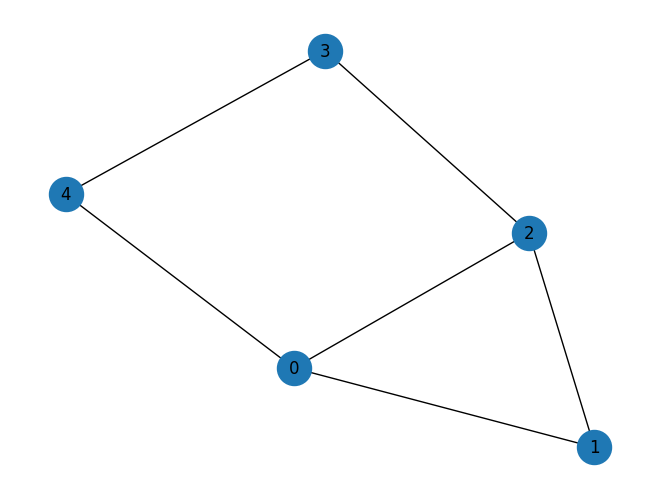

In [2]:
n = 5
 
graph = rx.PyGraph()    # Create an empty un-directed graph
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size = 600, with_labels = True)

In [23]:
graph.edge_list()

EdgeList[(0, 1), (0, 2), (0, 4), (1, 2), (2, 3), (3, 4)]

In [24]:
def build_max_cut_paulis(graph: rx.PyGraph()) -> list[tuple[str, float]]:
    """
    Convert the graph to Pauli list.
    This function does the inverse of `build_max_cut_graph`.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)
print("Pauli list:", max_cut_paulis)

cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("\nCost Function Hamiltonian:", cost_hamiltonian)

Pauli list: [('ZZ', [0, 1], 1.0), ('ZZ', [0, 2], 1.0), ('ZZ', [0, 4], 1.0), ('ZZ', [1, 2], 1.0), ('ZZ', [2, 3], 1.0), ('ZZ', [3, 4], 1.0)]

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


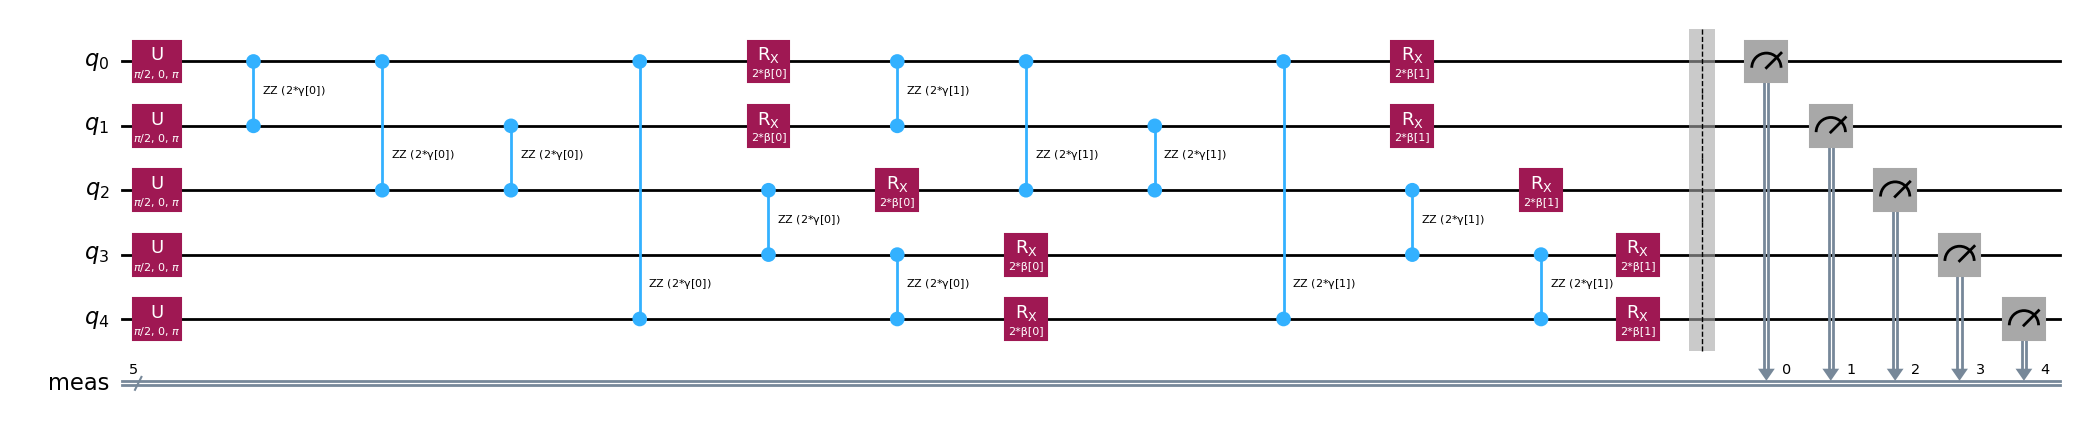

In [25]:
circuit = QAOAAnsatz(cost_operator = cost_hamiltonian, reps = 2)
circuit.measure_all()

circuit.decompose(reps = 2).draw("mpl", fold = -1)

In [26]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [27]:
service = QiskitRuntimeService()
backend = service.least_busy(operational = True, simulator = False, min_num_qubits = 127)
print(backend)

<IBMBackend('ibm_fez')>


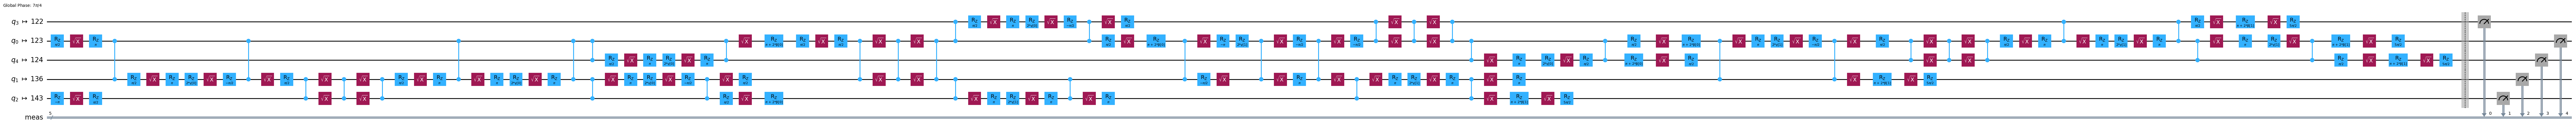

In [28]:
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)

isa_circuit = pm.run(circuit)
isa_circuit.draw("mpl", fold = -1, idle_wires = False)

In [ ]:
# Define initial parameters

initial_gamma = np.pi
initial_beta = np.pi/2
initial_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [41]:
def cost_func_estimator(params, ansatz_circ, hamiltonian, estimator):
    """
    Transform the observable defined on virtual qubits to an observable defined on all physical qubits
    """
    isa_cost_func = hamiltonian.apply_layout(ansatz_circ.layout)
    
    pub = (ansatz_circ, isa_cost_func, params)
    job = estimator.run([pub])
    
    results = job.result()[0]
    expect_value = results.data.evs
    
    objective_expect_vals.append(expect_value)
    
    return expect_value

In [42]:
objective_expect_vals = []

# with Session(backend = backend) as session:

estimator = Estimator(mode = backend)
estimator.options.default_shots = 1000

# Set simple error suppression/mitigation options
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"
estimator.options.twirling.enable_gates = True
estimator.options.twirling.num_randomizations  = "auto"

# minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
result = minimize(
    fun = cost_func_estimator,
    x0 = initial_params,
    args = (isa_circuit, cost_hamiltonian, estimator),
    method = "COBYLA",
    tol = 1e-2,
)

print(result)
print()
print(f"Parameters found: {result.x}")

In [43]:
# plt.figure(figsize=(12, 6))
# plt.plot(objective_expect_vals)
# plt.xlabel("Iteration")
# plt.ylabel("Cost")
# plt.show()

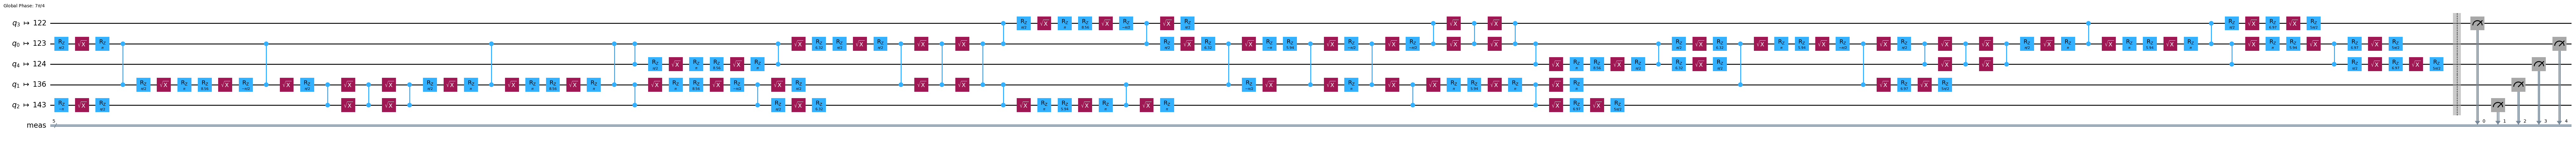

In [44]:
# If run in this session
# optimized_circuit = isa_circuit.assign_parameters(result.x)

# If run in a previous session --> parameters found in a previous run: [1.58705921 1.91177657 4.27784475 2.96796915]
optimized_circuit = isa_circuit.assign_parameters([1.58705921, 1.91177657, 4.27784475, 2.96796915])
optimized_circuit.draw("mpl", fold = -1, idle_wires = False)

In [45]:
sampler = Sampler(mode = backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit)
job = sampler.run([pub], shots = int(1e4))
print(f">>> Job ID: {job.job_id()}")

In [48]:
# job = service.job("...")

counts_int = job.result()[0].data.meas.get_int_counts()      # Dictionary key-counts, where keys are integer numbers corresponding to the binary representation of the states
counts_binary = job.result()[0].data.meas.get_counts()       # Dictionary key-counts, where keys are strings giving binary representation of the states
shots = sum(counts_int.values())

final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_binary = {key: val/shots for key, val in counts_binary.items()}

print(final_distribution_int)
print()
print(type(job.result()[0]))

{12: 0.0314, 18: 0.0727, 30: 0.0298, 7: 0.0357, 10: 0.0714, 21: 0.0687, 2: 0.0283, 20: 0.041, 13: 0.0661, 19: 0.0356, 11: 0.0436, 9: 0.0363, 22: 0.0385, 14: 0.0273, 5: 0.0305, 23: 0.0239, 26: 0.0291, 24: 0.0321, 4: 0.0316, 16: 0.0254, 8: 0.0282, 28: 0.0054, 27: 0.0289, 6: 0.0065, 29: 0.0309, 17: 0.0293, 1: 0.0303, 3: 0.0062, 15: 0.0209, 25: 0.0053, 0: 0.004, 31: 0.0051}

<class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>


In [47]:
# POST-PROCESSING

# auxiliary functions to sample the most likely bitstring
def to_bitstring(integer, num_bits):
    binary = np.binary_repr(integer, width = num_bits)    # a string with the binary representation of "integer"
    digits = [int(digit) for digit in binary]     # inary representation of "integer" in a list form
    return(digits)

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely_int_result = keys[np.argmax(np.abs(values))]
most_likely_binary_result = to_bitstring(most_likely_int_result, len(graph))
most_likely_binary_result.reverse()

print("Resulting bitstring:", most_likely_binary_result)

Resulting bitstring: [0, 1, 0, 0, 1]


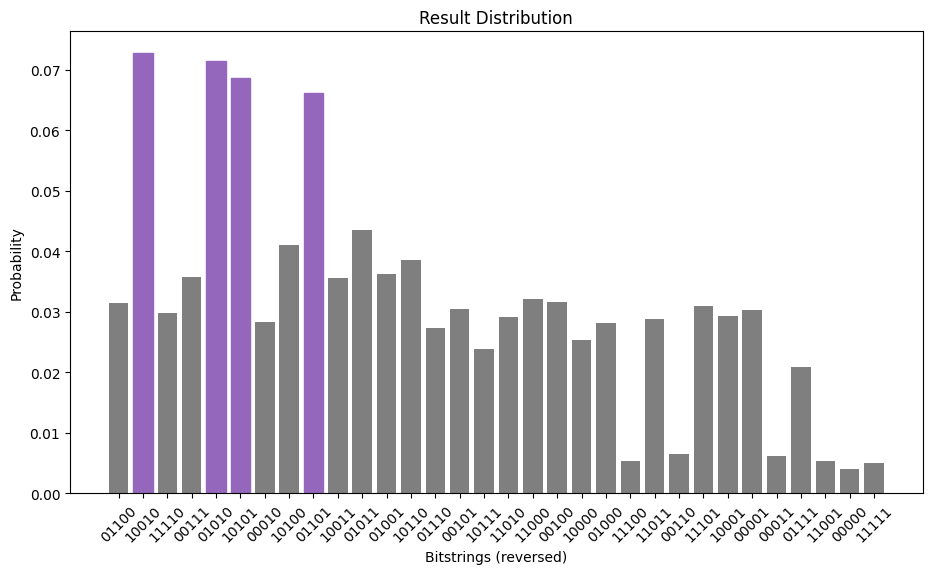

In [39]:
# Plot

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_binary
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

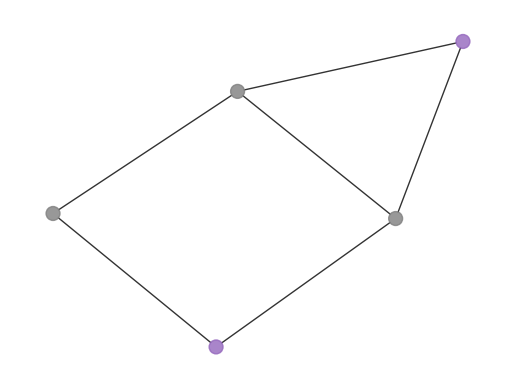

In [41]:
# Visualization

# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color = colors, node_size = 100, alpha = 0.8, pos = pos
    )
 
 
plot_result(graph, most_likely_binary_result)

In [43]:
# Calculate the value of the cut

def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in list(graph.edge_list())
    )
 
cut_value = evaluate_sample(most_likely_binary_result, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 4
